### Individual solution with the plots

In [8]:
using PyCall
using Distributions
using Statistics

using Distances
using Random , Formatting
using AstroLib

rootdir = "/home/stephane/Science/GAIA"

push!(LOAD_PATH,"$rootdir/master/src")
using GaiaClustering

import PyPlot

@pyimport astroquery.vizier as vizier
@pyimport astropy.units as u
@pyimport astropy.coordinates as coord


## directory
wdir    = "$rootdir/products"
plotdir = "$rootdir/products/test"

cd(wdir)

mutable struct twomass
    J::Array{Float64}
    Jerr::Array{Float64}
    H::Array{Float64}
    Herr::Array{Float64}
    K::Array{Float64}
    Kerr::Array{Float64}
end

In [9]:
#########
function _filter_data(gaia, dist_range = [0., 2000], vra_range = [-250,250], vdec_range = [-250.,250], mag_range =[-1e9, 1e9])::GaiaClustering.Df
########
    ngaia = length(gaia)
    
    println("## testing galactic pm")
    
    lgal = zeros(ngaia)
    bgal = zeros(ngaia) 
    ra = zeros(ngaia)
    dec= zeros(ngaia)
    distance = zeros(ngaia)  
    pmra = zeros(ngaia)
    pmdec = zeros(ngaia)    
    parallax = zeros(ngaia)
    vra = zeros(ngaia)
    vdec = zeros(ngaia)    
    g = zeros(ngaia)
    rp = zeros(ngaia)     
    bp = zeros(ngaia) 
    parallax_error = zeros(ngaia)
    pmra_error     = zeros(ngaia)
    pmdec_error    = zeros(ngaia)
    radialvel      = zeros(ngaia)
    
    ## Galactic proper motion
    pml = zeros(ngaia)
    pmb = zeros(ngaia)
    
    for i in 1:ngaia
        lgal[i]     = convert(Float64,gaia[i]["l"])
        bgal[i]     = convert(Float64,gaia[i]["b"])
        ra[i]       = convert(Float64,gaia[i]["ra"])
        dec[i]      = convert(Float64,gaia[i]["dec"])
        distance[i] = 1000. / convert(Float64,gaia[i]["parallax"])
        parallax[i] = convert(Float64,gaia[i]["parallax"])
        pmra[i]     = convert(Float64,gaia[i]["pmra"])
        pmdec[i]    = convert(Float64,gaia[i]["pmdec"])
        vra[i]      = 4.74e-3 * pmra[i]  * distance[i]
        vdec[i]     = 4.74e-3 * pmdec[i] * distance[i]
        ### errors.
        parallax_error[i]  = convert(Float64,gaia[i]["parallax_error"])
        pmra_error[i]  = convert(Float64,gaia[i]["pmra_error"])
        pmdec_error[i] = convert(Float64,gaia[i]["pmdec_error"])
        
        g[i]        = convert(Float64,gaia[i]["phot_g_mean_mag"])
        rp[i]       = convert(Float64,gaia[i]["phot_rp_mean_mag"])
        bp[i]       = convert(Float64,gaia[i]["phot_bp_mean_mag"])
        
        radialvel[i] = convert(Float64,gaia[i]["radial_velocity"])
        
        ## testing
        muG = PM_equatorial2galactic(pmra[i],pmdec[i]  , ra[i] , dec[i] , lgal[i])
        pml[i] = muG[1]
        pmb[i] = muG[2]
        vra[i]      = 4.74e-3 * pml[i]  * distance[i]
        vdec[i]     = 4.74e-3 * pmb[i]  * distance[i]
    end
    
    ## Filtering ...
    i1 =  distance .> dist_range[1]
    i2 =  distance .< dist_range[2]
    i3 =  vra .> vra_range[1]
    i4 =  vra .< vra_range[2]
    i5 =  vdec .> vdec_range[1]
    i6 =  vdec .< vdec_range[2]
    i7 = g  .> mag_range[1]
    i8 = g  .< mag_range[2]
    i9  = rp  .> mag_range[1]
    i10 = rp  .< mag_range[2]
    i11  = bp  .> mag_range[1]
    i12  = bp  .< mag_range[2]
     
    ifinal = i1 .& i2 .& i3 .& i4 .& i5 .& i6 .& i7 .& i8 .& i9 .& i10 .& i11 .& i12 
    
    ## G magnitude
     # gbar =  g[ifinal] - 5. * log10.(distance[ifinal]) + 17.
    gbar =  g[ifinal] - 5 .* log10.(distance[ifinal]) .+ 17.
    
    ## Df of the filtered dat
    ndata = length(distance[ifinal])
    s = GaiaClustering.Df(ndata, zeros(8,ndata), zeros(11,ndata) , zeros(8,ndata) )
    
    s.data[1,:] = lgal[ifinal]
    s.data[2,:] = bgal[ifinal]
    s.data[3,:] = distance[ifinal]
    s.data[4,:] = vra[ifinal]
    s.data[5,:] = vdec[ifinal]
    s.data[6,:] = gbar
    s.data[7,:] = g[ifinal] .- rp[ifinal]
    s.data[8,:] = bp[ifinal] .- g[ifinal]
    
    
    s.raw[1,:] = ra[ifinal]
    s.raw[2,:] = dec[ifinal]
    s.raw[3,:] = lgal[ifinal]
    s.raw[4,:] = bgal[ifinal]
    s.raw[5,:] = parallax[ifinal]
    s.raw[6,:] = pmra[ifinal]
    s.raw[7,:] = pmdec[ifinal]
    s.raw[8,:] = gbar
    s.raw[9,:] = rp[ifinal]
    s.raw[10,:] = bp[ifinal] 
    s.raw[11,:] = radialvel[ifinal]
 
    
    ## Errors ..
    s.err[1,:] = parallax_error[ifinal]
    s.err[4,:] = pmra_error[ifinal]
    s.err[5,:] = pmdec_error[ifinal]
    
    println("## Filtering done ...")
    println("## Stars selected: $ndata")
    
    return(s)
end


_filter_data (generic function with 5 methods)

In [10]:
## Transform PM from equatorial to galactic system.
## See Poleski 1997 / arXiv
## PM,,corr is from Conrad (2015)

function PM_equatorial2galactic(μα , μδ , α , δ , l )
    αG = 192.85948
    δG = 27.12825
    
    C1 = sind(δG)*cosd(δ) - cosd(δG)*sind(δ)*cosd(α - αG)
    C2 =  cosd(δG)*sind(α - αG)
    k = 1 / sqrt(C1^2 + C2^2)
    A = k * [C1 C2 ; -C2 C1]
    PMG = A * [μα ; μδ ]
    
    ## PM along gal. lat. corrected for differential velocity 
    ## Oort constants
    A , B = (14.5 , -13.) ./ 4.74
    PMG[1] =  PMG[1] - (A*cosd(2l) + B)
    
    return(PMG)
end

PM_equatorial2galactic (generic function with 1 method)

In [11]:
function _getdata(filevot , wghtblck)
    voname = filevot

    data       = read_votable(voname)
    df         = filter_data(data)
    dfcart     = add_cartesian(df)
    blck       = [[1,2,3],[4,5], [6,7,8]]
    # wghtblck   = [4.0,5.0,1.0]
    # wghtblck   = [3.03, 9.05, 1.83]
    norm       = "identity"

    dfcartnorm , scale8 = normalization_PerBlock(dfcart, blck, wghtblck , norm, false) 
    return(df, dfcart , dfcartnorm)
end

_getdata (generic function with 1 method)

In [12]:
## Get the 2Mass Magnitudes

function _get_2MASS(indx, df::GaiaClustering.Df)
    s = length(indx)
    tm = twomass(zeros(s),zeros(s),zeros(s),zeros(s),zeros(s),zeros(s)) 
    
    for i in 1:s
        c = coord.SkyCoord(ra= df.raw[1,indx[i]], dec=df.raw[2,indx[i]]  , unit=(u.deg, u.deg), frame="icrs")
        res = vizier.Vizier[:query_region](c , width="5s",catalog="II/246")
        if length(res) > 0
            tm.J[i]    = res[1][1][4][1]
            tm.Jerr[i] = res[1][1][5][1]
            tm.H[i]    = res[1][1][6][1]
            tm.Herr[i] = res[1][1][7][1]
            tm.K[i]    = res[1][1][8][1]
            tm.Kerr[i] = res[1][1][9][1]            
        end
    end
    return(tm)
end
    

_get_2MASS (generic function with 1 method)

In [13]:
## label from the dbscan labels with maximum stars
function _find_cluster_label(labels)
    let
    i = 1 ; nmax = 0 ; ilabel = 1
        for ilab in labels
            nlab = length(ilab)
            if nlab > nmax
                ilabel = i
                nmax= nlab
            end
            i += 1
        end
    return(ilabel, nmax)
    end
end


function _plot_cluster(plotdir, voname, indx, sc::GaiaClustering.SCproperties, tm::twomass , df::GaiaClustering.Df, showplot = true , cmap = "gist_stern")

    PyPlot.plt[:figure](figsize=(12.0,12.0))

    PyPlot.plt[:subplot](3, 3, 1 , xlim = [-20,20] , ylim = [-20,20])
    xx = df.data[2,indx]
    yy = df.data[3,indx]
    ## A circle of radius std(z)
    # xc = mean(df.data[2,indx]) ; yc = mean(df.data[3,indx])
    # circle1 = PyPlot.plt[:Circle](0.,0.,1.)
    PyPlot.plt[:scatter](xx, yy , s = 1.0 )
    PyPlot.plt[:xlabel]("Y (pc)")
    PyPlot.plt[:ylabel]("Z (pc)")
    PyPlot.plt[:grid](true)
    
    PyPlot.plt[:subplot](3, 3, 2 , ylim = [-20,20])
    xx = df.data[1,indx]
    yy = df.data[3,indx]
    PyPlot.plt[:scatter](xx, yy , s = 1.0 )
    PyPlot.plt[:xlabel]("X (pc)")
    PyPlot.plt[:ylabel]("Z (pc)")
    PyPlot.plt[:grid](true)
    
    PyPlot.plt[:subplot](3, 3, 3 , xlim = [-20,20])
    xx = df.data[2,indx]
    yy = df.data[1,indx]
    PyPlot.plt[:scatter](xx, yy , s = 1.0 )
    PyPlot.plt[:xlabel]("Y (pc)")
    PyPlot.plt[:ylabel]("X (pc)")
    PyPlot.plt[:grid](true)
    
    PyPlot.plt[:subplot](3, 3, 4 )
    xx = df.data[1,indx]
    yy = df.raw[13,indx]
    PyPlot.plt[:scatter](xx, yy , s = 1.0 )
    PyPlot.plt[:xlabel]("X(pc)")
    PyPlot.plt[:ylabel]("Vrad (km/s)")
    PyPlot.plt[:grid](true)    
        
    PyPlot.plt[:subplot](3, 3, 5)
    PyPlot.plt[:axis]("off")
    ## text to display
    text =[]
    v = sc.nstars ; txt = "N stars   : $v" ; push!(text,txt)
    v = fmt("3.1f",sc.distance) ; txt = "Distance  : $v (pc)" ; push!(text,txt)
    v = fmt("3.3f",sc.l) ; txt = "l         : $v (degree)" ; push!(text,txt)
    v = fmt("3.3f",sc.b) ; txt = "b         : $v (degree)" ; push!(text,txt)
    v = fmt("3.2f", sc.vl) ; txt = "Vl      : $v (km/s)" ; push!(text,txt)
    v = fmt("3.2f",sc.vb) ; txt = "Vb      : $v (km/s)"; push!(text,txt)
    v = fmt("3.2f",sc.vrad) ; txt = "Vradial   : $v (km/s)"; push!(text,txt)    
    v = fmt("3.2f",sc.xdisp) ; txt = "X disp.   : $v (pc)" ; push!(text,txt)
    v = fmt("3.2f",sc.ydisp) ; txt = "Y disp.   : $v (pc)" ; push!(text,txt)
    v = fmt("3.2f",sc.zdisp) ; txt = "Z disp.   : $v (pc)" ; push!(text,txt)
    v = fmt("3.2f",sc.vldisp) ; txt = "Vl disp. : $v (km/s)" ; push!(text,txt)
    v = fmt("3.2f",sc.vbdisp) ; txt = "Vb disp.: $v (km/s)" ; push!(text,txt)
    v = fmt("3.2f",sc.vraddisp) ; txt = "Vradial disp.: $v (km/s)" ; push!(text,txt)
    show_text(-0.01,0.0, text , 1.0)
    
    PyPlot.plt[:subplot](3, 3, 7 )
    PyPlot.plt[:axis]("on")    
    xx = df.data[7,indx]
    yy = -df.data[6,indx]
    PyPlot.plt[:scatter](xx, yy , s = 1.0 )
    PyPlot.plt[:xlabel]("G-Rp")
    PyPlot.plt[:ylabel]("G")
    PyPlot.plt[:grid](true)
    
    PyPlot.plt[:subplot](3, 3, 8 )
    xx = df.data[4,indx]
    yy = df.data[5,indx]
    PyPlot.plt[:scatter](xx, yy , s = 1.0 )
    PyPlot.plt[:xlabel]("Vl (km/s)")
    PyPlot.plt[:ylabel]("Vb (km/s)")
    PyPlot.plt[:grid](true)
    
    PyPlot.plt[:subplot](3, 3, 9 , ylim =[-17,-6.])
    yy = -tm.J[:]
    xx = tm.J[:] .- tm.K[:]
    PyPlot.plt[:scatter](xx, yy , s = 1.0 )
    PyPlot.plt[:ylabel]("J")
    PyPlot.plt[:xlabel]("J-K")
    PyPlot.plt[:grid](true)
    
    
    figname = plotdir*"/"*voname*"-cluster.png"
    PyPlot.plt[:savefig](figname)
    if showplot PyPlot.plt[:show]() end
end

_plot_cluster (generic function with 3 methods)

## Main ...
ϵ : 2.2
## Votable test.vot read
## Filtering done ...
## Stars selected: 143644
## Cartesian transformation done ...
## Normalization identity done...
### [1pc,1pc,1pc,1km/s,1km/s,1mag,1mag,1mag] equivalent to [0.21351, 0.21351, 0.21351, 0.637712, 0.637712, 0.128952, 0.128952, 0.128952]
##
## dbscan..
## Search for 2MASS counterparts...
## done.
### 5 clusters found.
### Label solution: 1
### N stars: 3757
GaiaClustering.SCproperties(3757, 414.6568886435583, 119.51179994354075, -60.767597313008686, 273.83623917520663, -15.86819851062313, 2.4283033389801876, -4.699809768987506, 11.206977745470164, -6.344427226270739, 1.0201807869417647, -12.428771210795135, 2.0019067200312506, 25.045534383507626, 34.14446480534123, 7.900464238185478, 5.769241572921543, 1.6469577015271506, 1.3274655284490378, 6.5052419093774905)


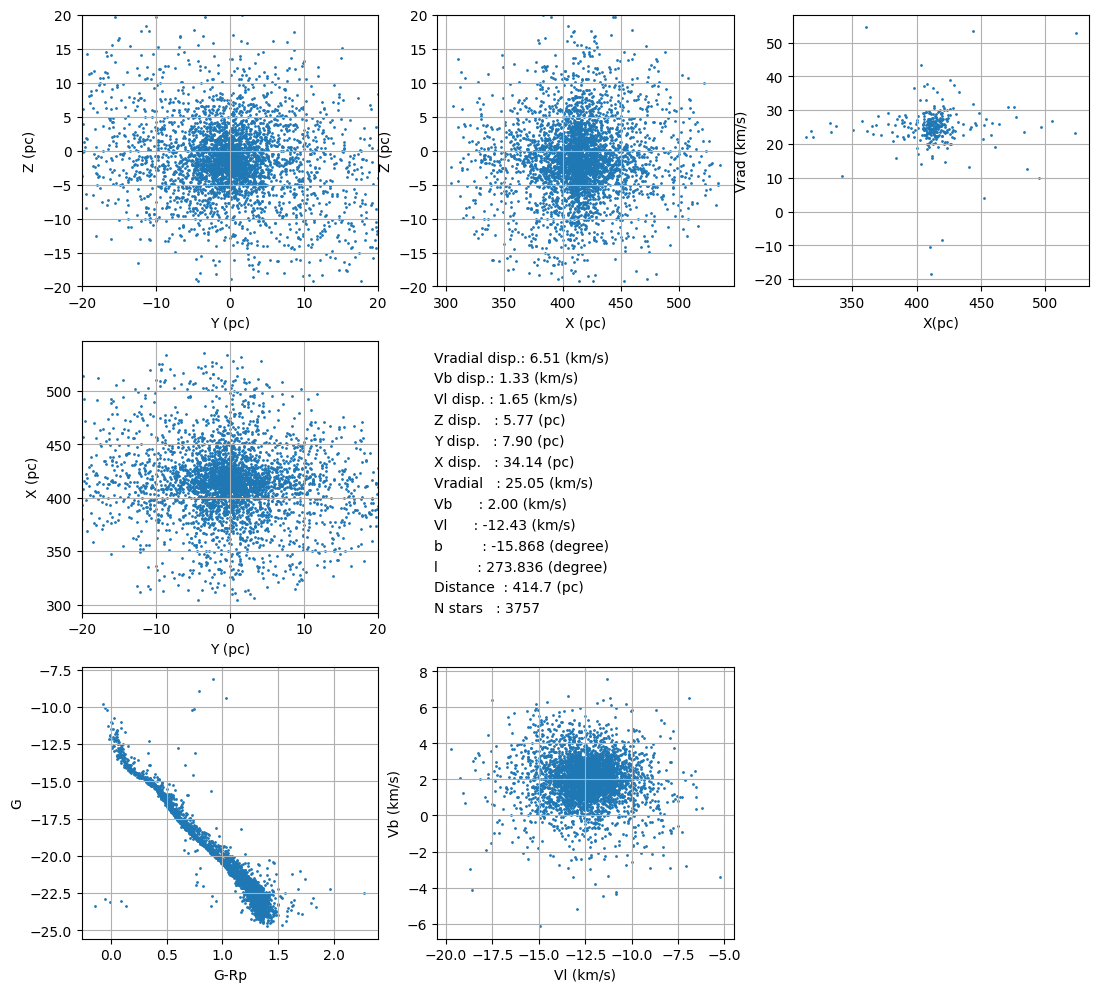

 
-5.774301255090966
pml:-12.118728481361703
pmb:1.0201807869417647
## Galactic velocity:
U: 21.94
V: -26.16
W: -4.93


In [14]:
macro main(votname)
    Random.seed!(1237)
    println("## Main ...")
    

    wghtblck   = [3.03, 9.05, 1.83]
    
    eps = 2.2
    min_nei = 7
    min_cl = 17
    println("ϵ : $eps")

    ## Get the cluster data..
    df ,  dfcart, dfnorm = _getdata(votname , wghtblck)
    
    println("## dbscan..")
    labels = clusters(dfnorm.data , eps , 20, min_nei, min_cl)
    labelmax , nmax = find_cluster_label(labels)
    println("## Search for 2MASS counterparts...")
    tmass = _get_2MASS(labels[labelmax] , df)
    println("## done.")
    
    println("### $(length(labels)) clusters found.")
    println("### Label solution: $labelmax")
    println("### N stars: $nmax")
    sc = get_properties_SC(labels[labelmax] , df, dfcart)
    println(sc)
    
    plot_cluster(plotdir, votname, labels[labelmax], sc ,  dfcart )
    #_plot_cluster(plotdir, votname, labels[labelmax], sc , tmass,  dfcart )
    
    ## SC kinematics
    println(" ")
    A , B = (14.5 , -13.) ./ 4.74
    kk = (A*cosd(2sc.l) + B)
    println(kk)
    println("pml:",sc.pml+kk)
    println("pmb:",sc.pmb)
    #println(sc.parallax)
    println("## Galactic velocity:")
     u,v,w = gal_uvw(sc.ra, sc.dec, sc.pmra, sc.pmdec, sc.vrad , sc.parallax)
     s1= fmt("3.2f",u) ; println("U: $s1")
     s2= fmt("3.2f",v) ; println("V: $s2")
     s3= fmt("3.2f",w) ; println("W: $s3")
end

@main("test.vot")